# Silverbox

Silverbox refers to one of the nonlinear system identification benchmarks on http://nonlinearbenchmark.org/#Silverbox. 
It is a simulation of a [Duffing oscillator](https://en.wikipedia.org/wiki/Duffing_equation), ocurring for instance in nonlinear spring pendulums.

State-space model description of the system:

$$\begin{align}
m \frac{d^2 x(t)}{dt^2} + v \frac{d x(t)}{dt} + a x(t) + b x^3(t) =&\ u(t) + w(t) \\
y(t) =&\ x(t) + e(t)
\end{align}$$

where
$$\begin{align}
m     =&\ \text{mass} \\
v     =&\ \text{viscous damping} \\
a     =&\ \text{linear stiffness} \\
b     =&\ \text{nonlinear stiffness} \\
y(t)    =&\ \text{observation (displacement)} \\
x(t)    =&\ \text{state (displacement)} \\
u(t)    =&\ \text{force} \\
e(t)    =&\ \text{measurement noise} \\
w(t)    =&\ \text{process noise}
\end{align}$$

The process noise is a Wiener process, where the increment is Gaussian distributed $w(t) = \frac{d B(t)}{dt} \sim \mathcal{N}(0, \tau^{-1}dt)$. The parameter $\tau$ represents the precision of the process. The same holds for the measurement noise.

## Solution steps

### 1. Discretize

I'm now using a central difference for the second derivative and a forward difference for the first derivative:

$$\begin{align}
x''(t) \approx&\ \frac{x(t+h) - 2x(t) + x(t-h)}{h^2} = \frac{x_{t+1} - 2x_{t} + x_{t-1}}{(\Delta t)^2}\\
x'(t) \approx&\ \frac{x(t+h) - x(t)}{h} = \frac{x_{t+1} - x_{t}}{\Delta t}\\
\end{align}$$

where $\Delta t = t - (t-1) = 1$. Let $w_t$ be a sample from $\mathcal{N}(0, \tau^{-1})$. The DE can now be written as the following discrete-time system:

$$\begin{align}
m (x_{t+1} - 2x_{t} + x_{t-1}) + v (x_{t+1} - x_{t}) + a x_t + b x_t^3 =&\ u_t + w_t
\end{align}$$

Re-writing this as a function of $x_{t+1}$ yields:
$$\begin{align}
(m + v) x_{t+1}&\ + (-2m - v + a) x_{t} + bx_t^3 + m x_{t-1} = u_t + w_t \\
% x_t + \frac{-2m - v}{m + v + a} x_{t-1} + \frac{m}{m + v + a} x_{t-2} =&\ \frac{1}{m + v + a} u_t + \frac{1}{m + v + a} w_t \\
x_{t+1}&\ = \frac{2m + v - a}{m + v} x_{t} + \frac{-b}{m + v}x_t^3 + \frac{-m}{m + v} x_{t-1} + \frac{1}{m + v} u_t + \frac{1}{m + v} w_t \, .
\end{align}$$

### 2. Convert to multivariate first-order form

I can cast the above system into matrix form:

$$ \underbrace{\begin{bmatrix} x_{t+1} \\ x_{t} \end{bmatrix}}_{z_t} = \underbrace{\begin{bmatrix} \frac{2m+v-a}{m+v} - \frac{b}{m+v}x_t^2 & \frac{-m}{m+v} \\ 1 & 0 \end{bmatrix} \begin{bmatrix} x_{t} \\ x_{t-1} \end{bmatrix}}_{A(\theta, z_{t-1})} + \begin{bmatrix} \frac{1}{m+v} \\ 0 \end{bmatrix} u_t + \begin{bmatrix} 1 \\ 0 \end{bmatrix} \tilde{w}_t \, ,$$

where $A(\theta, z_{t-1}) = Sz_{t-1} + c g(z_{t-1}, \theta)$ with the familiar shifting operator $S$ and selection variable $c$, $g(z_{t-1}, \theta) = \theta_1 x_t + \theta_2 x_t^3 + \theta_3 x_{t-1}$ and

$$\begin{align}
\theta_1 =&\ \frac{2m+v-a}{m+v} \\
\theta_2 =&\ \frac{-b}{m+v} \\
\theta_3 =&\ \frac{-m}{m+v} \, .
\end{align}$$

Additionally, I'll introduce $\eta = 1/(m+v)$. I can absorb $\eta$ into $w_t$: $\mathbb{V}[\eta w_t] = \eta^2 \mathbb{V}[w_t] = \eta^2 \tau^{-1}$. I will rename $\eta^2 \tau^{-1}$ as $\gamma^{-1}$ and let $\tilde{w}_t \sim \mathcal{N}(0, \gamma^{-1})$. In total, I have five unknowns $m,v,a,b,\tau$ and five equations. We can solve the nonlinear system of equations to obtain estimates of the physical parameters from the shorthand parameters. The shorthands have the benefit that they allow for some freedom in choosing priors. The downside is that we lose the confidence estimate.

The system is now a nonlinear autoregressive process:

$$z_t = A(\theta, z_{t-1}) + c\eta u_t + \tilde{w}_t$$

Note that we need a two-dimensional state prior now (reminiscent of adding an initial condition on the velocity).

### 3. Convert to Gaussian probability

Integrating out $\tilde{w}_t$ produces a Gaussian state transition node:

$$z_t \sim \mathcal{N}(A(\theta, z_{t-1}) + c\eta u_t, V)$$

where $V = \begin{bmatrix} \gamma^{-1} & 0 \\ 0 & \epsilon \end{bmatrix}$ and $V^{-1} = W = \begin{bmatrix} \gamma & 0 \\ 0 & 1/\epsilon \end{bmatrix}$.

The observation likelihood maps to

$$y_t \sim \mathcal{N}(c^{\top} z_t, \xi^{-1})$$

where $e_t \sim \mathcal{N}(0, \xi^{-1})$.

### 6. Choose priors

We currently have unknown parameters $\psi = (\theta_1, \theta_2, \theta_3, \eta, \gamma)$. Since they are substitutions, we don't know anything about their support directly. We do know about it indirectly, from the nonlinear combinations of the physical coefficients. We know that mass $m$ and process precision $\gamma$ are strictly positive parameters and that the damping and stiffness coefficients can be both positive and negative. Hence, by examing the nonlinear transform $\psi = G(\phi)$;

$$\begin{align} 
\theta_1 =&\ \frac{2m+v-a}{m+v} \\
\theta_2 =&\ \frac{-b}{m+v} \\
\theta_3 =&\ \frac{-m}{m+v} \\
\eta =&\ \frac{1}{m+v} \\
\gamma^{-1} =&\ \frac{1}{\tau (m + v)^2} \, .
\end{align}$$

we realize that $\theta_1$, $\theta_2$, $\theta_3$ and $\eta$ can be both positive and negative, but $\gamma$ can only be positive. As such, we choose the following priors:

$$\begin{align}
\theta \sim&\ \mathcal{N}(m^{0}_{\theta}, V^{0}_{\theta}) \\
\eta \sim&\ \mathcal{N}(m^{0}_{\eta}, v^{0}_{\eta}) \\ 
\gamma \sim&\ \Gamma(a^{0}_\gamma, b^{0}_\gamma) 
\end{align}$$

Modeling $\theta = (\theta_1, \theta_2, \theta_3)$ as a joint Gaussian allows for incorporating it into an Autoregressive node.

### 7. Recover physical variables from substituted ones

Since we have five equations and five unknowns, we can perfectly recover point estimates of the physical variables from substituted ones. However, we don't want point estimates, we want posteriors. 

If we approximate $\gamma$ with a log-Normal distribution and then map it to a Gaussian distribution (i.e. model $\tilde{\gamma} = \log(\gamma)$), we end up with a Gaussian distributed random vector $\psi = [\theta_1, \theta_2, \theta_3, \eta, \tilde{\gamma}]$. We can perform a Gaussian approximation of the inverse mapping $G^{-1}(\psi)$ using a first-order Taylor expansion:

$$\begin{align}
m_{\phi} \triangleq \mathbb{E}[G^{-1}(\psi)] =&\ G^{-1}(m_{\psi}) \\
V_{\phi} \triangleq \mathbb{V}[G^{-1}(\psi)] =&\ J_{\psi}(m_{\psi}) G^{-1}(m_{\psi}) J_{\psi}(m_{\psi})^{\top} \, ,
\end{align}$$

The inverse mapping has the form:

$$\begin{align} 
m =&\ \frac{-\theta_3}{\eta} \\
v =&\ \frac{1+\theta_3}{\eta} \\
a =&\ \frac{(1-\theta_1 - \theta_3)}{\eta} \\
b =&\ \frac{-\theta_2}{\eta} \\
\tau =&\ \tilde{\gamma} \eta^2 \, .
\end{align}$$

The Jacobian can be obtained automatically using Julia packages such as ForwardDiff.jl or Zygote.jl. However, since each component of $\phi$ is Gaussian distributed, we have actually modeled $\tilde{m} = \log(m)$ and $\tilde{\tau} = \log(\tau)$. We still need to map these to log-Normal distributions to recover $m$ and $\tau$. If $x \sim \mathcal{N}(m_x, v_x)$ and $y = \exp(x) \sim \mathcal{LN}(m_y, v_y)$, then

$$\begin{align}
m_y =&\ \exp(m_x + \frac{1}{2}v_x) \\
v_y =&\ \exp(2m_x + v_x) \big(\exp(v_x)-1 \big) \, ,
\end{align}$$

and

$$\begin{align}
m_x =&\ 2\log(m_y) - \frac{1}{2}\log(v_y + m_y^2) \\
v_x =&\ -2\log(m_y) + \log \big(v_y + m_y^2 \big) \, .
\end{align}$$

### Data

Let's first have a look at the data.

In [1]:
using Revise
using CSV
using DataFrames

In [2]:
using Plots
viz = true;

In [3]:
# Read data from CSV file
df = CSV.read("../data/SNLS80mV.csv", ignoreemptylines=true)
df = select(df, [:V1, :V2])

# Shorthand
input = df[:,1]
output = df[:,2]

# Time horizon
T = size(df, 1);

In [4]:
# Plot every n-th time-point to avoid figure size exploding
n = 20

20

In [5]:
if viz
    p1a = Plots.plot(1:n:T, output[1:n:T], color="black", label="", markersize=2, xlabel="time (t)", ylabel="output (displacement)", size=(1200,400))    
    Plots.savefig(p1a, "viz/output_signal.png")
end

In [6]:
if viz
    p2a = Plots.plot(1:n:T, input[1:n:T], color="black", label="", markersize=2, xlabel="time (t)", ylabel="input (control)", size=(1200,400))
    Plots.savefig(p2a, "viz/input_signal.png")
end

## Estimating parameters via Bayesian filtering

Implementation with ForneyLab and AR node. The AR node is locally modified from the package LAR (LAR is in dev mode). It now contains an AutoregressiveControlNL node, where I can add a nonlinearity g as an argument.

The major change from a linear AR to a nonlinear AR node is in working out the expectations for $g(x,\theta)$ as opposed to $\theta^{\top}x$. There are a number of ways of doing this. I have chosen a first-order Taylor approximation:

$$ g(x,\theta) = g(m_x, m_{\theta}) + J_{x}(m_x, m_{\theta})^{\top}(x - m_x) + J_{\theta}(m_x, m_{\theta})^{\top}(\theta - m_{\theta}) \, ,$$

where $J_x$ denotes the partial derivative of $g$ with respect to $x$ and $J_{\theta}$ w.r.t. $\theta$. Note that our current $g$ is linear in $\theta$ and you could argue that you don't need to approximate it. However, the first-order Taylor is exact in that case. The expectations are:

#### First-order

- W.r.t. both $x$ and $\theta$:
$$\begin{align}
\mathbb{E}_{q(x),q(\theta)}[ g(x,\theta)] =&\ \mathbb{E}_{q(x),q(\theta)}[ g(m_x, m_{\theta}) + J_{x}(m_x, m_{\theta})^{\top}(x - m_x) + J_{\theta}(m_x, m_{\theta})^{\top}(\theta - m_{\theta}) ] \\
=&\ g(m_x, m_{\theta}) + J_{x}(m_x, m_{\theta})^{\top}\underbrace{\mathbb{E}_{q(x)}[(x - m_x)]}_{0} + J_{\theta}(m_x, m_{\theta})^{\top}\underbrace{\mathbb{E}_{q(\theta)}[(\theta - m_{\theta})]}_{0} \\
=&\ g(m_x, m_{\theta}) \, .
\end{align}$$

- W.r.t. $x$:
$$\begin{align}
\mathbb{E}_{q(x)}[ g(x,\theta)] =&\ \mathbb{E}_{q(x)}[ g(m_x, m_{\theta}) + J_{x}(m_x, m_{\theta})^{\top}(x - m_x) + J_{\theta}(m_x, m_{\theta})^{\top}(\theta - m_{\theta}) ] \\
=&\ g(m_x, m_{\theta}) + J_{x}(m_x, m_{\theta})^{\top}\underbrace{\mathbb{E}_{q(x)}[(x - m_x)]}_{0} + J_{\theta}(m_x, m_{\theta})^{\top}(\theta - m_{\theta}) \\
=&\ g(m_x, m_{\theta}) + J_{\theta}(m_x, m_{\theta})^{\top}(\theta - m_{\theta}) \\
\propto&\ J_{\theta}(m_x, m_{\theta})^{\top}\theta \, .
\end{align}$$

- W.r.t. $\theta$:
$$\begin{align}
\mathbb{E}_{q(x),q(\theta)}[ g(x,\theta)] =&\ \mathbb{E}_{q(x),q(\theta)}[ g(m_x, m_{\theta}) + J_{x}(m_x, m_{\theta})^{\top}(x - m_x) + J_{\theta}(m_x, m_{\theta})^{\top}(\theta - m_{\theta}) ] \\
=&\ g(m_x, m_{\theta}) + J_{x}(m_x, m_{\theta})^{\top}(x - m_x) + J_{\theta}(m_x, m_{\theta})^{\top}\underbrace{\mathbb{E}_{q(\theta)}[(\theta - m_{\theta})]}_{0} \\
=&\ g(m_x, m_{\theta}) + J_{x}(m_x, m_{\theta})^{\top}(x - m_x) \\
\propto&\ J_{x}(m_x, m_{\theta})^{\top}x \, .
\end{align}$$

#### Second-order

Shorthand: $g$ for $g(m_x, m_\theta)$, $J_x$ for $J_x(m_x, m_{\theta})$ and $J_{\theta}(m_x, m_{\theta})$.

- W.r.t. both $x$ and $\theta$:
$$\begin{align}
\mathbb{E}_{q(x),q(\theta)}[ g(x,\theta)^2] =&\ \mathbb{E}_{q(x),q(\theta)}[ \big( g + J_{x}^{\top}(x - m_x) + J_{\theta}^{\top}(\theta - m_{\theta}) \big)^2] \\
=&\ g^{2} + 2 g J_{x}^{\top}\underbrace{\mathbb{E}_{q(x)}[(x - m_x)]}_{0}  + 2 g J_{\theta}^{\top}\underbrace{\mathbb{E}_{q(\theta)}[(\theta - m_{\theta})]}_{0} + 2 J_{x}^{\top}\underbrace{\mathbb{E}_{q(x)}[(x - m_x)]}_{0} J_{\theta}^{\top}\underbrace{\mathbb{E}_{q(\theta)}[(\theta - m_{\theta})]}_{0} \\
&\ + J_x^{\top}\mathbb{E}_{q(x)}[(x - m_x)(x - m_x)^{\top}]J_x + J_{\theta}^{\top}\mathbb{E}_{q(\theta)}[(\theta - m_{\theta})(\theta - m_{\theta})^{\top}] J_{\theta} \\
=&\ g^{2} + J_x^{\top} V_x J_x + J_{\theta}^{\top} V_{\theta} J_{\theta} \, .
\end{align}$$

- W.r.t. $x$:
$$\begin{align}
\mathbb{E}_{q(x)}[ g(x,\theta)^2] =&\ \mathbb{E}_{q(x)}[ \big( g + J_{x}^{\top}(x - m_x) + J_{\theta}^{\top}(\theta - m_{\theta}) \big)^2] \\
=&\ g^{2} + 2 g J_{x}^{\top}\underbrace{\mathbb{E}_{q(x)}[(x - m_x)]}_{0}  + 2 g J_{\theta}^{\top}(\theta - m_{\theta}) + 2 J_{x}^{\top}\underbrace{\mathbb{E}_{q(x)}[(x - m_x)]}_{0} J_{\theta}^{\top}(\theta - m_{\theta}) \\
&\ + J_x^{\top}\mathbb{E}_{q(x)}[(x - m_x)(x - m_x)^{\top}]J_x + J_{\theta}^{\top}(\theta - m_{\theta})(\theta - m_{\theta})^{\top} J_{\theta} \\
=&\ g^{2} + 2 g J_{\theta}^{\top}(\theta - m_{\theta}) + J_{\theta}^{\top} V_{\theta} J_{\theta} + J_x^{\top} V_x J_x \\
\propto&\ (g-J_{\theta}^{\top}m_{\theta}) J_{\theta}^{\top}\theta + \theta^{\top}J_{\theta}(g - J_{\theta}^{\top}m_{\theta}) + \theta^{\top} J_{\theta} J_{\theta}^{\top} \theta \, .
\end{align}$$

- W.r.t. $\theta$:
$$\begin{align}
\mathbb{E}_{q(\theta)}[ g(x,\theta)^2] =&\ \mathbb{E}_{q(\theta)}[ \big( g + J_{x}^{\top}(x - m_x) + J_{\theta}^{\top}(\theta - m_{\theta}) \big)\big(\dots \big)^{\top}] \\
=&\ g^{2} + 2 g J_{x}^{\top}(x - m_x)  + 2 g J_{\theta}^{\top}\underbrace{\mathbb{E}_{q(\theta)}[(\theta - m_{\theta})]}_{0} + 2 J_{x}^{\top}(x - m_x) J_{\theta}^{\top}\underbrace{\mathbb{E}_{q(\theta)}[(\theta - m_{\theta})]}_{0} \\
&\ + J_x^{\top}(x - m_x)(x - m_x)^{\top}J_x + J_{\theta}^{\top}\mathbb{E}_{q(\theta)}[(\theta - m_{\theta})(\theta - m_{\theta})^{\top}] J_{\theta} \\
=&\ g^{2} + 2 g J_{x}^{\top}(x - m_x) + J_x^{\top} (x - m_x)(x - m_x)^{\top} J_x + J_{\theta}^{\top} V_{\theta} J_{\theta} \\
\propto&\ (g-J_x^{\top}m_x) J_x^{\top}x + x^{\top}J_x(g - J_x^{\top}m_x) + x^{\top} J_x J_x^{\top} x \, .
\end{align}$$


In [7]:
using LinearAlgebra
using ForneyLab
using ForneyLab: unsafeMean, unsafeCov, unsafeVar, unsafePrecision
using LAR
using LAR.Node, LAR.Data
using ProgressMeter

In [8]:
using Zygote

function Jacobian(F, x)
    y = F(x)
    n = length(y)
    m = length(x)
    T = eltype(y)
    j = Array{T, 2}(undef, n, m)
    for i in 1:n
        j[i, :] .= gradient(x -> F(x)[i], x)[1]
    end
    return j
end;

In [9]:
# Start graph
graph = FactorGraph()

# Static parameters
@RV θ ~ GaussianMeanPrecision(placeholder(:m_θ, dims=(3,)), placeholder(:w_θ, dims=(3,3)))
@RV η ~ GaussianMeanPrecision(placeholder(:m_η), placeholder(:w_η))
@RV γ ~ Gamma(placeholder(:a_γ), placeholder(:b_γ))
@RV ξ ~ Gamma(placeholder(:a_ξ), placeholder(:b_ξ))

# Nonlinearity
g(x,θ) = θ[1]*x[1] + θ[2]*x[1]^3 + θ[3]*x[2]

# State prior
@RV z_t ~ GaussianMeanPrecision(placeholder(:m_z, dims=(2,)), placeholder(:w_z, dims=(2, 2)), id=:z_t)

# Autoregressive node
@RV x_t ~ AutoregressiveControlNL(θ, z_t, η, placeholder(:u_t), γ, g=g, id=:x_t)

# Specify likelihood
@RV y_t ~ GaussianMeanPrecision(dot([1. , 0.], x_t), ξ, id=:y_t)

# Placeholder for observation
placeholder(y_t, :y_t)

# Draw time-slice subgraph
ForneyLab.draw(graph)

<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.40.1 (20161225.0304)
 -->
<!-- Title: G Pages: 1 -->
 
 
 G 
 
<!-- 12954278698175757532 -->
 
 12954278698175757532 
 
 𝒩 
 gaussianmeanprecision_2 
 
<!-- 14025980669407136135 -->
 
 14025980669407136135 
 
 placeholder_m_η 
 
<!-- 12954278698175757532--14025980669407136135 -->
 
 12954278698175757532--14025980669407136135 
 
 m_η 
 1 out 
 2 m 
 
<!-- 15039105545058396303 -->
 
 15039105545058396303 
 
 placeholder_w_η 
 
<!-- 12954278698175757532--15039105545058396303 -->
 
 12954278698175757532--15039105545058396303 
 
 w_η 
 1 out 
 3 w 
 
<!-- 1335457153373454973 -->
 
 1335457153373454973 
 
 𝒩 
 z_t 
 
<!-- 5850243531782884891 -->
 
 5850243531782884891 
 
 placeholder_m_z 
 
<!-- 1335457153373454973--5850243531782884891 -->
 
 1335457153373454973--5850243531782884891 
 
 m_z 
 1 out 
 2 m 
 
<!-- 11971688902103238137 -->
 
 11971688902103238137 
 
 placeholder_w_z 
 
<!-- 1335457153373454973--11971688902103238137 -->
 
 1335457153373454973--11971688902103238137 
 
 w_z 
 1 out 
 3 w 
 
<!-- 8911786476245532515 -->
 
 8911786476245532515 
 
 placeholder_a_γ 
 
<!-- 8887616719082944832 -->
 
 8887616719082944832 
 
 𝒩 
 y_t 
 
<!-- 6451635729366589933 -->
 
 6451635729366589933 
 
 dot 
 dotproduct_1 
 
<!-- 8887616719082944832--6451635729366589933 -->
 
 8887616719082944832--6451635729366589933 
 
 variable_1 
 1 out 
 2 m 
 
<!-- 15249349266857294647 -->
 
 15249349266857294647 
 
 Gam 
 gamma_2 
 
<!-- 8887616719082944832--15249349266857294647 -->
 
 8887616719082944832--15249349266857294647 
 
 ξ 
 1 out 
 3 w 
 
<!-- 551145449808204963 -->
 
 551145449808204963 
 
 placeholder_y_t 
 
<!-- 551145449808204963--8887616719082944832 -->
 
 551145449808204963--8887616719082944832 
 
 y_t 
 1 out 
 1 out 
 
<!-- 910285588599954389 -->
 
 910285588599954389 
 
 placeholder_b_γ 
 
<!-- 17063628029817671357 -->
 
 17063628029817671357 
 
 placeholder_a_ξ 
 
<!-- 12295750174828278908 -->
 
 12295750174828278908 
 
 𝒩 
 gaussianmeanprecision_1 
 
<!-- 16095406024333882389 -->
 
 16095406024333882389 
 
 placeholder_m_θ 
 
<!-- 12295750174828278908--16095406024333882389 -->
 
 12295750174828278908--16095406024333882389 
 
 m_θ 
 1 out 
 2 m 
 
<!-- 10615025376420466151 -->
 
 10615025376420466151 
 
 placeholder_w_θ 
 
<!-- 12295750174828278908--10615025376420466151 -->
 
 12295750174828278908--10615025376420466151 
 
 w_θ 
 1 out 
 3 w 
 
<!-- 6687447215098101273 -->
 
 6687447215098101273 
 
 clamp_1 
 
<!-- 4784462358302753854 -->
 
 4784462358302753854 
 
 placeholder_u_t 
 
<!-- 6451635729366589933--6687447215098101273 -->
 
 6451635729366589933--6687447215098101273 
 
 clamp_1 
 1 out 
 3 in2 
 
<!-- 13900452191111428302 -->
 
 13900452191111428302 
 
 ARCNL 
 x_t 
 
<!-- 6451635729366589933--13900452191111428302 -->
 
 6451635729366589933--13900452191111428302 
 
 x_t 
 1 y 
 2 in1 
 
<!-- 15249349266857294647--17063628029817671357 -->
 
 15249349266857294647--17063628029817671357 
 
 a_ξ 
 1 out 
 2 a 
 
<!-- 2600492758982127 -->
 
 2600492758982127 
 
 placeholder_b_ξ 
 
<!-- 15249349266857294647--2600492758982127 -->
 
 15249349266857294647--2600492758982127 
 
 b_ξ 
 1 out 
 3 b 
 
<!-- 13900452191111428302--12954278698175757532 -->
 
 13900452191111428302--12954278698175757532 
 
 η 
 1 out 
 4 η 
 
<!-- 13900452191111428302--1335457153373454973 -->
 
 13900452191111428302--1335457153373454973 
 
 z_t 
 1 out 
 2 x 
 
<!-- 13900452191111428302--12295750174828278908 -->
 
 13900452191111428302--12295750174828278908 
 
 θ 
 1 out 
 3 θ 
 
<!-- 13900452191111428302--4784462358302753854 -->
 
 13900452191111428302--4784462358302753854 
 
 u_t 
 1 out 
 5 u 
 
<!-- 17108814998717940929 -->
 
 17108814998717940929 
 
 Gam 
 gamma_1 
 
<!-- 13900452191111428302--17108814998717940929 -->
 
 13900452191111428302--17108814998717940929 


In [10]:
# Infer an algorithm
q = PosteriorFactorization(z_t, x_t, θ, η, γ, ξ, ids=[:z, :x, :θ, :η, :γ, :ξ])
algo = variationalAlgorithm(q, free_energy=false)
source_code = algorithmSourceCode(algo, free_energy=false)
eval(Meta.parse(source_code));
# println(source_code)

In [24]:
# Looking at only the first few timepoints
# T = 10000
T = size(df, 1);

# Inference parameters
num_iterations = 10

# Initialize marginal distribution and observed data dictionaries
data = Dict()
marginals = Dict()

# Initialize arrays of parameterizations
params_x = (zeros(2,T+1), repeat(.1 .*float(eye(2)), outer=(1,1,T+1)))
params_θ = (ones(3,T+1), repeat(.1 .*float(eye(3)), outer=(1,1,T+1)))
params_η = (ones(1,T+1), .1*ones(1,T+1))
params_γ = (1. *ones(1,T+1), 1. *ones(1,T+1))
params_ξ = (1. *ones(1,T+1), 1. *ones(1,T+1))

# Initialize physical coefficient estimate arrays
params_ϕ = (zeros(5,T), zeros(5,5,T))
params_ψ = (zeros(5,T), zeros(5,5,T))
params_m = (zeros(T,), zeros(T,))
params_v = (zeros(T,), zeros(T,))
params_a = (zeros(T,), zeros(T,))
params_b = (zeros(T,), zeros(T,))
params_τ = (zeros(T,), zeros(T,))

# Transformations between physical and substituted variables: ψ = G(ϕ) => ϕ = G_inv(ψ)
G(ϕ) = [(2*ϕ[1] + ϕ[2] - ϕ[3])/(ϕ[1]+ϕ[2]), -ϕ[4]/(ϕ[1]+ϕ[2]), -ϕ[1]/(ϕ[1]+ϕ[2]), 1/(ϕ[1]+ϕ[2]), ϕ[5]*(ϕ[1]+ϕ[2])^2]
G_inv(ψ) = [-ψ[3]/ψ[4], (1+ψ[3])/ψ[4], (1 - ψ[1] - ψ[3])/ψ[4], -ψ[2]/ψ[4], ψ[5]*ψ[4]^2]

# Start progress bar
p = Progress(T, 1, "At time ")

# Perform inference at each time-step
for t = 1:T

    # Update progress bar
    update!(p, t)
    
    "Filtering"

    # Initialize marginals
    marginals[:x_t] = ProbabilityDistribution(Multivariate, GaussianMeanPrecision, m=params_x[1][:,t], w=params_x[2][:,:,t])
    marginals[:z_t] = ProbabilityDistribution(Multivariate, GaussianMeanPrecision, m=params_x[1][:,t], w=params_x[2][:,:,t])
    marginals[:θ] = ProbabilityDistribution(Multivariate, GaussianMeanPrecision, m=params_θ[1][:,t], w=params_θ[2][:,:,t])
    marginals[:η] = ProbabilityDistribution(Univariate, GaussianMeanPrecision, m=params_η[1][1,t], w=params_η[2][1,t])
    marginals[:γ] = ProbabilityDistribution(Univariate, Gamma, a=params_γ[1][1,t], b=params_γ[2][1,t])
    marginals[:ξ] = ProbabilityDistribution(Univariate, Gamma, a=params_ξ[1][1,t], b=params_ξ[2][1,t])
    
    data = Dict(:y_t => output[t],
                :u_t => input[t],
                :m_z => params_x[1][:,t],
                :w_z => params_x[2][:,:,t],
                :m_θ => params_θ[1][:,t],
                :w_θ => params_θ[2][:,:,t],
                :m_η => params_η[1][1,t],
                :w_η => params_η[2][1,t],
                :a_γ => params_γ[1][1,t],
                :b_γ => params_γ[2][1,t],
                :a_ξ => params_ξ[1][1,t],
                :b_ξ => params_ξ[2][1,t])

    # Iterate variational parameter updates
    for i = 1:num_iterations

        stepx!(data, marginals)
        stepθ!(data, marginals)
        stepη!(data, marginals)
        stepγ!(data, marginals)
        stepξ!(data, marginals)
    end

    # Store current parameterizations of marginals
    params_x[1][:,t+1] = unsafeMean(marginals[:x_t])
    params_x[2][:,:,t+1] = marginals[:x_t].params[:w]
    params_θ[1][:,t+1] = unsafeMean(marginals[:θ])
    params_θ[2][:,:,t+1] = marginals[:θ].params[:w]
    params_η[1][1,t+1] = unsafeMean(marginals[:η])
    params_η[2][1,t+1] = marginals[:η].params[:w]
    params_γ[1][1,t+1] = marginals[:γ].params[:a]
    params_γ[2][1,t+1] = marginals[:γ].params[:b]
    params_ξ[1][1,t+1] = marginals[:ξ].params[:a]
    params_ξ[2][1,t+1] = marginals[:ξ].params[:b]
    
    "Map substituted to physical variables via first-order Taylor"
    
    # Approximate gamma with log-normal via moment-matching
    Eγ = unsafeMean(marginals[:γ])
    Vγ = unsafeVar(marginals[:γ])
    m_γ = log(Eγ^2/sqrt(Vγ + Eγ^2))
    v_γ = log(Vγ/Eγ^2 + 1)

    # Construct vector of parameter estimates ψ
    m_ψ = [unsafeMean(marginals[:θ])[1], unsafeMean(marginals[:θ])[2], unsafeMean(marginals[:θ])[3], unsafeMean(marginals[:η])[1], m_γ]
#     V_ψ = unsafeCov(marginals[:θ])Diagonal([var(marginals[:θ])[1], var(marginals[:θ])[2], var(marginals[:θ])[3], var(marginals[:η])[1], v_γ])
    V_ψ = [unsafeCov(marginals[:θ]) zeros(3,2); zeros(2,3) [unsafeCov(marginals[:η])[1,1] 0;0 v_γ]]
    
    # Compute Jacobian of transformation 
    J_ψ = Jacobian(G_inv, m_ψ)
    
    # Compute moments of transformed Gaussian using first-order Taylor approx
    m_ϕ = G_inv(m_ψ)
    V_ϕ = J_ψ*V_ψ*J_ψ'

    # Split ϕ into physical coefficients
    m_m, m_v, m_a, m_b, m_τ = m_ϕ
    v_m, v_v, v_a, v_b, v_τ = Diagonal(V_ϕ)
    
    # Store param estimates for mass
    params_m[1][t] = m_m
    params_m[2][t] = v_m
    
    # Store param estimates for friction
    params_v[1][t] = m_v
    params_v[2][t] = v_v
    
    # Store param estimates for linear stiffness
    params_a[1][t] = m_a
    params_a[2][t] = v_a
    
    # Store param estimates for nonlinear stiffness
    params_b[1][t] = m_b
    params_b[2][t] = v_b
    
    # Store param estimates for process precision
    params_τ[1][t] = m_τ
    params_τ[2][t] = v_τ
    
    # Store original parameters as well
    params_ϕ[1][:,t] = m_ϕ
    params_ϕ[2][:,:,t] = V_ϕ
    params_ψ[1][:,t] = m_ψ
    params_ψ[2][:,:,t] = V_ψ

end

At time 100%|███████████████████████████████████████████| Time: 0:03:04


### Visualize results

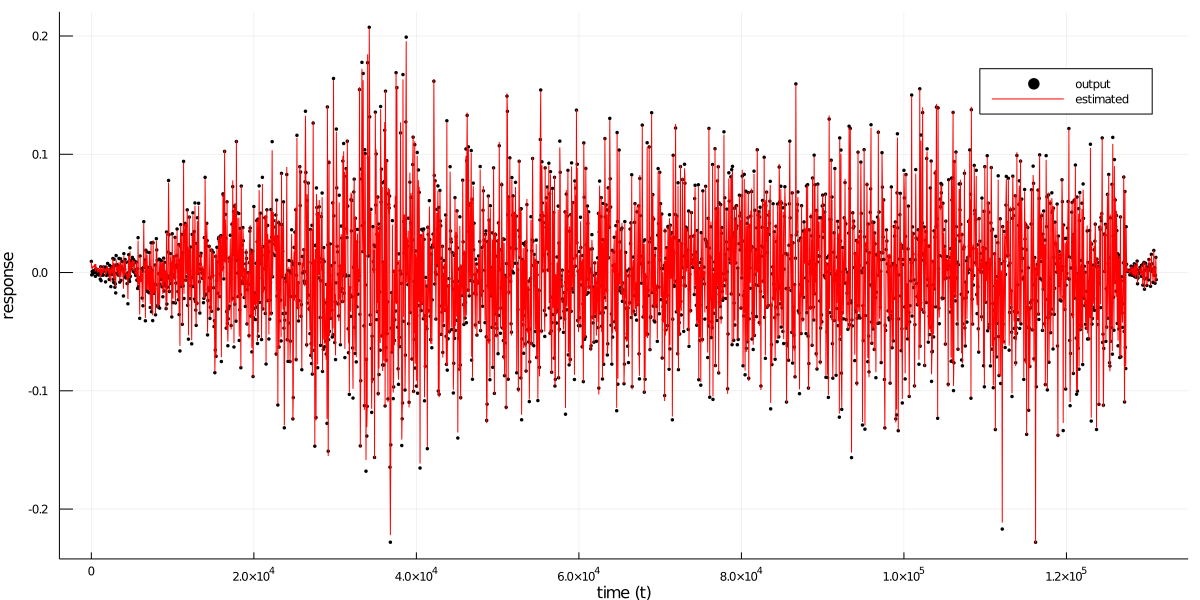

In [26]:
# Extract mean of state marginals
estimated_states = params_x[1][1,2:end]

if viz
    # Plot every n-th time-point to avoid figure size exploding
    n = 50
    p1 = Plots.scatter(1:n:T, output[1:n:T], color="black", label="output", markersize=2, size=(1200,600), xlabel="time (t)", ylabel="response")
    Plots.plot!(1:n:T, estimated_states[1:n:T], color="red", linewidth=1, label="estimated")
#     Plots.savefig(p1, "viz/nonlin_estimated_states01.png")
end

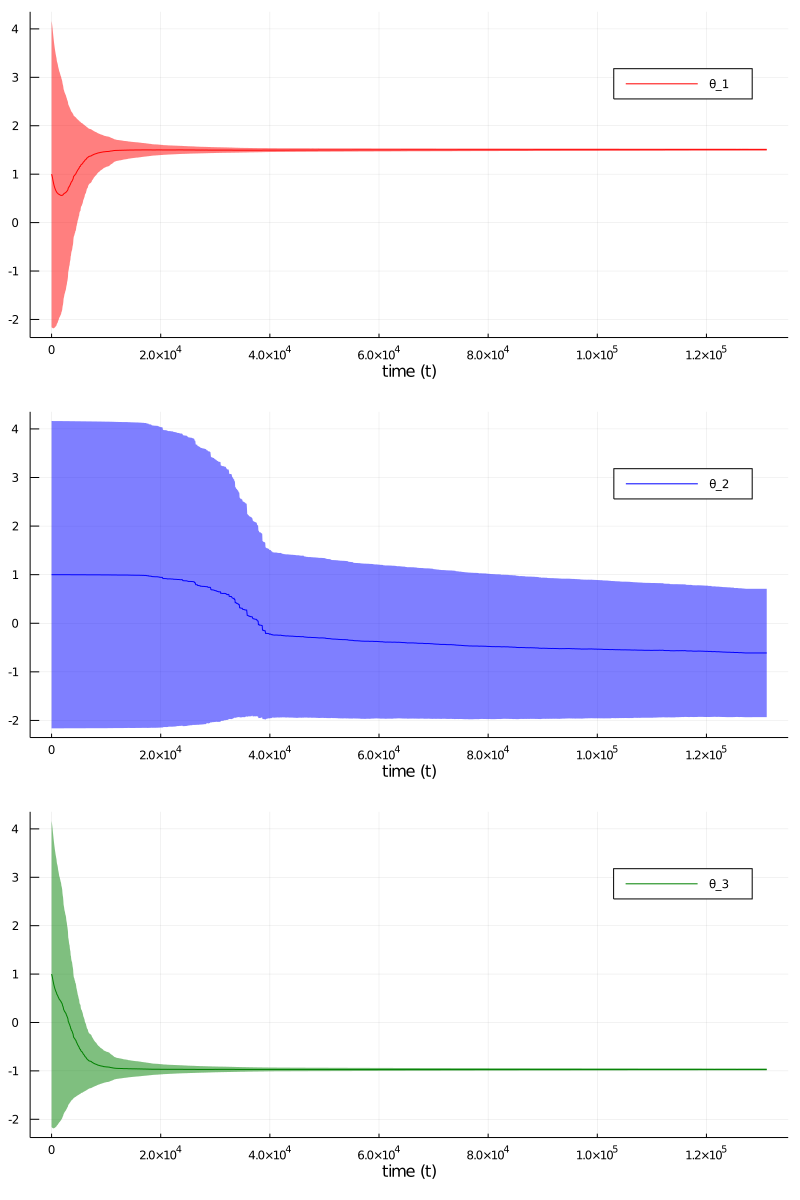

In [27]:
# Extract mean of coefficient marginals
estimated_θ1_mean = params_θ[1][1,2:end]
estimated_θ2_mean = params_θ[1][2,2:end]
estimated_θ3_mean = params_θ[1][3,2:end]
estimated_θ1_std = sqrt.(inv.(params_θ[2][1,1,2:end]))
estimated_θ2_std = sqrt.(inv.(params_θ[2][2,2,2:end]))
estimated_θ3_std = sqrt.(inv.(params_θ[2][3,3,2:end]))

if viz
    
    # Plot both coefficients next to each other
    p2a = Plots.plot(1:n:T, estimated_θ1_mean[1:n:T], ribbon=[estimated_θ1_std[1:n:T], estimated_θ1_std[1:n:T]], color="red", label="θ_1", xlabel="time (t)")
    p2b = Plots.plot(1:n:T, estimated_θ2_mean[1:n:T], ribbon=[estimated_θ2_std[1:n:T], estimated_θ2_std[1:n:T]], color="blue", label="θ_2", xlabel="time (t)")
    p2c = Plots.plot(1:n:T, estimated_θ3_mean[1:n:T], ribbon=[estimated_θ3_std[1:n:T], estimated_θ3_std[1:n:T]], color="green", label="θ_3", xlabel="time (t)")
    p2 = plot(p2a, p2b, p2c, layout=(3,1), size=(800,1200))
#     Plots.savefig(p2, "viz/nonlin_estimated_θ.png")
end

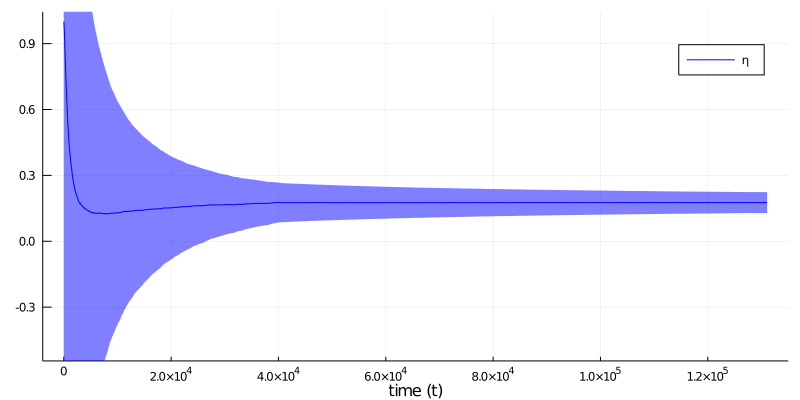

In [28]:
# Extract mean of control coefficient marginals
estimated_η_mean = params_η[1][1,2:end]
estimated_η_std = sqrt.(inv.(params_η[2][1,2:end]))

if viz
    # Plot both coefficients next to each other
    p3 = Plots.plot(1:n:T, estimated_η_mean[1:n:T], ribbon=[estimated_η_std[1:n:T], estimated_η_std[1:n:T]], color="blue", label="η", xlabel="time (t)", ylim=[-.5, 1.], size=(800,400))
#     Plots.savefig(p3, "viz/nonlin_estimated_η.png")
end

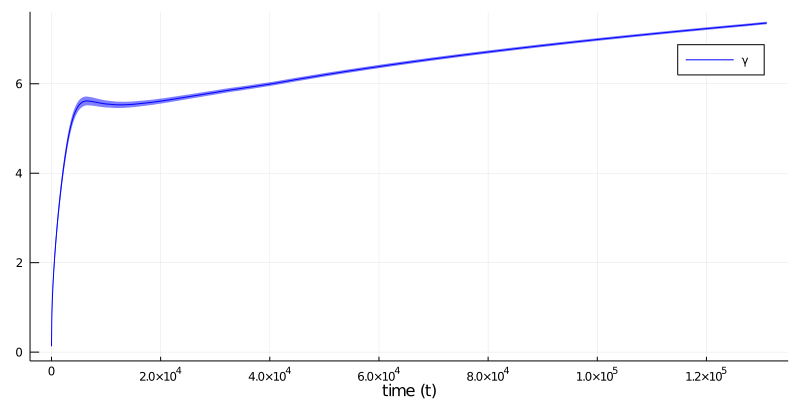

In [29]:
# Extract mean of process precision marginals
estimated_γ_mean = params_γ[1][1,2:end] ./ params_γ[2][1,2:end]
estimated_γ_std = sqrt.(params_γ[1][1,2:end] ./ params_γ[2][1,2:end].^2)

if viz
    # Plot both coefficients next to each other
    p4 = Plots.plot(1:n:T, estimated_γ_mean[1:n:T], ribbon=[estimated_γ_std[1:n:T], estimated_γ_std[1:n:T]], color="blue", label="γ", xlabel="time (t)", size=(800,400))
#     Plots.savefig(p4, "viz/nonlin_estimated_γ.png")
end

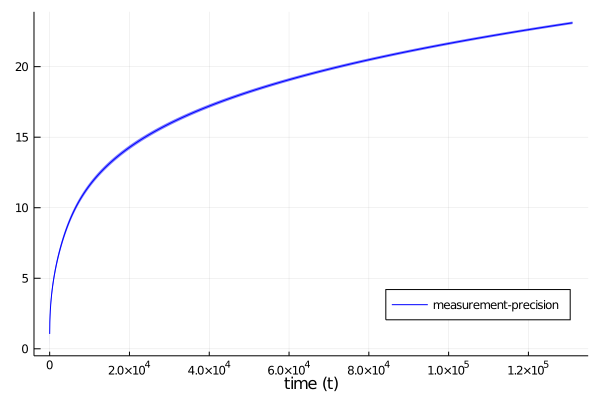

In [30]:
# Extract mean of measurement precision marginals
estimated_ξ_mean = params_ξ[1][1,2:end] ./ params_ξ[2][1,2:end]
estimated_ξ_std = sqrt.(params_ξ[1][1,2:end] ./ params_ξ[2][1,2:end].^2)

if viz
    # Plot both coefficients next to each other
    p8 = Plots.plot(1:n:T, estimated_ξ_mean[1:n:T], ribbon=[estimated_ξ_std[1:n:T], estimated_ξ_std[1:n:T]], color="blue", label="measurement-precision", xlabel="time (t)", size=(600,400), legend=:bottomright)
#     Plots.savefig(p8, "viz/nonlin_estimated_measurement-precision_600x400.png")
end

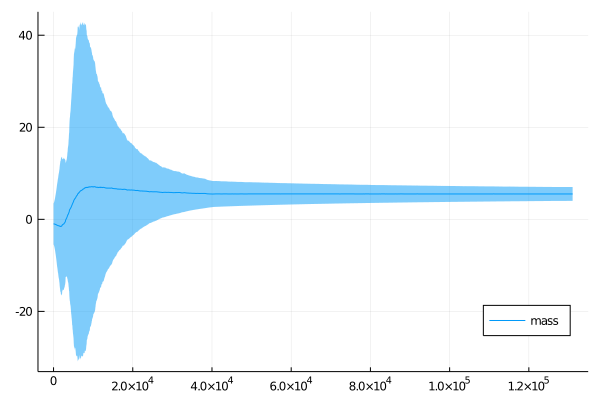

In [67]:
# Visualize estimates of mass
p11 = plot(1:n:T, params_m[1][1:n:T], ribbon=[sqrt.(params_m[2][1:n:T]) sqrt.(params_m[2][1:n:T])], label="mass", legend=:bottomright)
# Plots.savefig(p11, "viz/nonlin-1taylor_estimated_mass.png")

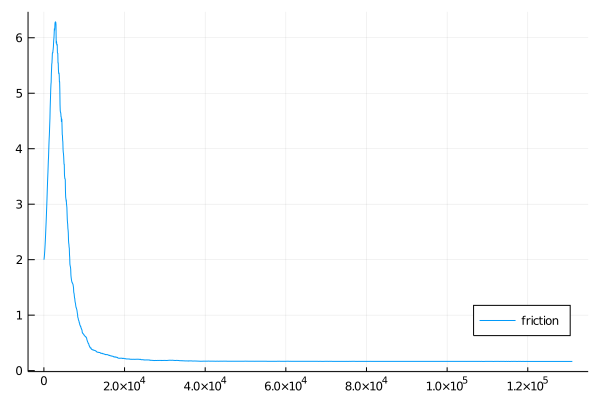

In [68]:
# Visualize estimates of friction
p12 = plot(1:n:T, params_v[1][1:n:T], ribbon=[sqrt.(params_v[2][1:n:T]) sqrt.(params_v[2][1:n:T])], label="friction", legend=:bottomright)
# Plots.savefig(p12, "viz/nonlin-1taylor_estimated_friction.png")

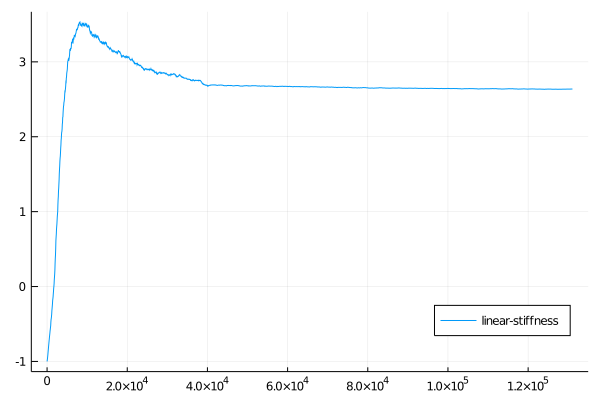

In [69]:
# Visualize estimates of linear stiffness
p13 = plot(1:n:T, params_a[1][1:n:T], ribbon=[sqrt.(params_a[2][1:n:T]) sqrt.(params_a[2][1:n:T])], label="linear-stiffness", legend=:bottomright)
# Plots.savefig(p13, "viz/nonlin-1taylor_estimated_lin-stiffness.png")

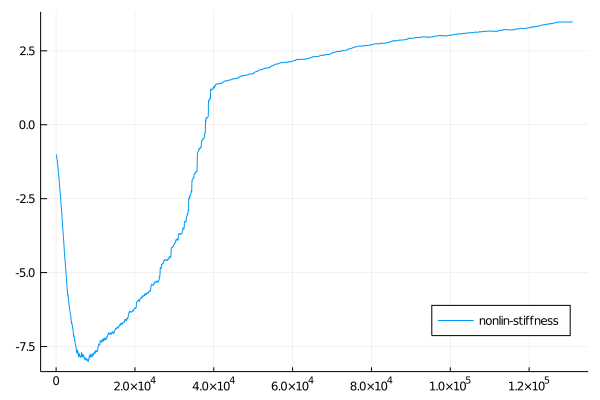

In [70]:
# Visualize estimates of nonlinear stiffness
p14 = plot(1:n:T, params_b[1][1:n:T], ribbon=[sqrt.(params_b[2][1:n:T]) sqrt.(params_b[2][1:n:T])], label="nonlin-stiffness", legend=:bottomright)
# Plots.savefig(p14, "viz/nonlin-1taylor_estimated_nonlin-stiffness.png")

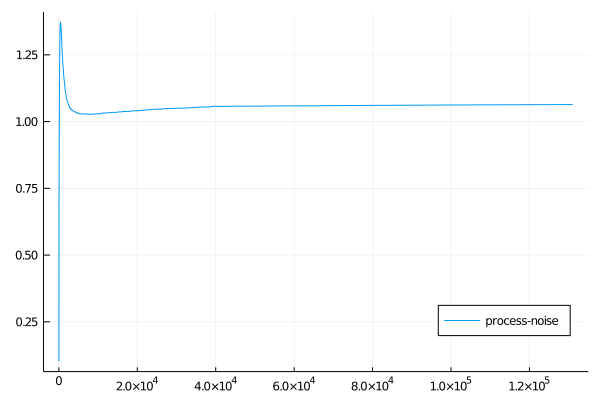

In [71]:
# Map process noise back to log-normal distribution
m_lτ = exp.(params_τ[1] .+ params_τ[2]./ 2.)
v_lτ = exp.(2 .*params_τ[1] .+ params_τ[2]).*(exp.(params_τ[2]) .- 1)

# Visualize estimates of process noise
# plot(1:n:T, params_τ[1][1:n:T], ribbon=[sqrt.(params_τ[2][1:n:T]) sqrt.(params_τ[2][1:n:T])], label="process-noise", legend=:bottomright)
p15 = plot(1:n:T, m_lτ[1:n:T], ribbon=[sqrt.(v_lτ[1:n:T]) sqrt.(v_lτ[1:n:T])], label="process-noise", legend=:bottomright)
# Plots.savefig(p15, "viz/nonlin-1taylor_estimated_process-noise.png")